In [1]:
#!pip install scipy==1.1.0

Saved to reverse_forward_kl.pdf
Saved to reverse_forward_kl.png


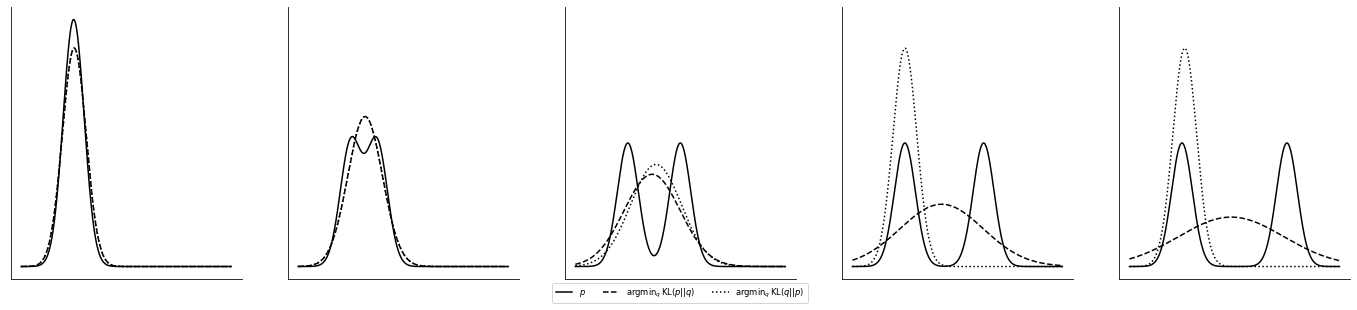

In [4]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns


class GaussianMixture1D:
    def __init__(self, mixture_probs, means, stds):
        self.num_mixtures = len(mixture_probs)
        self.mixture_probs = mixture_probs
        self.means = means
        self.stds = stds

    def sample(self, num_samples=1):
        mixture_ids = np.random.choice(self.num_mixtures, size=num_samples, p=self.mixture_probs)
        result = np.zeros([num_samples])
        for sample_idx in range(num_samples):
            result[sample_idx] = np.random.normal(
                loc=self.means[mixture_ids[sample_idx]],
                scale=self.stds[mixture_ids[sample_idx]]
            )
        return result

    def logpdf(self, samples):
        mixture_logpdfs = np.zeros([len(samples), self.num_mixtures])
        for mixture_idx in range(self.num_mixtures):
            mixture_logpdfs[:, mixture_idx] = scipy.stats.norm.logpdf(
                samples,
                loc=self.means[mixture_idx],
                scale=self.stds[mixture_idx]
            )
        return sp.special.logsumexp(mixture_logpdfs + np.log(self.mixture_probs), axis=1)

    def pdf(self, samples):
        return np.exp(self.logpdf(samples))


def approx_kl(gmm_p, gmm_q, xs):
    ys = gmm_p.pdf(xs) * (gmm_p.logpdf(xs) - gmm_q.logpdf(xs))
    return np.trapz(ys, xs)


def minimize_pq(p, xs, q_means, q_stds):
    q_mean_best = None
    q_std_best = None
    kl_best = np.inf
    for q_mean in q_means:
        for q_std in q_stds:
            q = GaussianMixture1D(np.array([1]), np.array([q_mean]), np.array([q_std]))
            kl = approx_kl(p, q, xs)
            if kl < kl_best:
                kl_best = kl
                q_mean_best = q_mean
                q_std_best = q_std

    q_best = GaussianMixture1D(np.array([1]), np.array([q_mean_best]), np.array([q_std_best]))
    return q_best, kl_best


def minimize_qp(p, xs, q_means, q_stds):
    q_mean_best = None
    q_std_best = None
    kl_best = np.inf
    for q_mean in q_means:
        for q_std in q_stds:
            q = GaussianMixture1D(np.array([1]), np.array([q_mean]), np.array([q_std]))
            kl = approx_kl(q, p, xs)
            if kl < kl_best:
                kl_best = kl
                q_mean_best = q_mean
                q_std_best = q_std

    q_best = GaussianMixture1D(np.array([1]), np.array([q_mean_best]), np.array([q_std_best]))
    return q_best, kl_best


def main():
    p_second_means_min = 0
    p_second_means_max = 10
    num_p_second_means = 5
    p_second_mean_list = np.linspace(p_second_means_min, p_second_means_max, num_p_second_means)

    p = [None] * num_p_second_means
    q_best_forward = [None] * num_p_second_means
    kl_best_forward = [None] * num_p_second_means
    q_best_reverse = [None] * num_p_second_means
    kl_best_reverse = [None] * num_p_second_means

    for p_second_mean_idx, p_second_mean in enumerate(p_second_mean_list):
        p_mixture_probs = np.array([0.5, 0.5])
        p_means = np.array([0, p_second_mean])
        p_stds = np.array([1, 1])
        p[p_second_mean_idx] = GaussianMixture1D(p_mixture_probs, p_means, p_stds)

        q_means_min = np.min(p_means) - 1
        q_means_max = np.max(p_means) + 1
        num_q_means = 20
        q_means = np.linspace(q_means_min, q_means_max, num_q_means)

        q_stds_min = 0.1
        q_stds_max = 5
        num_q_stds = 20
        q_stds = np.linspace(q_stds_min, q_stds_max, num_q_stds)

        trapz_xs_min = np.min(np.append(p_means, q_means_min)) - 3 * np.max(np.append(p_stds, q_stds_max))
        trapz_xs_max = np.max(np.append(p_means, q_means_min)) + 3 * np.max(np.append(p_stds, q_stds_max))
        num_trapz_points = 1000
        trapz_xs = np.linspace(trapz_xs_min, trapz_xs_max, num_trapz_points)

        q_best_forward[p_second_mean_idx], kl_best_forward[p_second_mean_idx] = minimize_pq(
            p[p_second_mean_idx], trapz_xs, q_means, q_stds
        )
        q_best_reverse[p_second_mean_idx], kl_best_reverse[p_second_mean_idx] = minimize_qp(
            p[p_second_mean_idx], trapz_xs, q_means, q_stds
        )

    # plotting
    fig, axs = plt.subplots(nrows=1, ncols=num_p_second_means, sharex=True, sharey=True)
    fig.set_size_inches(24, 5)
    for p_second_mean_idx, p_second_mean in enumerate(p_second_mean_list):
        xs_min = -5
        xs_max = 15
        num_plot_points = 1000
        xs = np.linspace(xs_min, xs_max, num_plot_points)
        axs[p_second_mean_idx].plot(xs, p[p_second_mean_idx].pdf(xs), label='$p$', color='black')
        axs[p_second_mean_idx].plot(xs, q_best_forward[p_second_mean_idx].pdf(xs), label='$\mathrm{argmin}_q \,\mathrm{KL}(p || q)$', color='black', linestyle='dashed')
        axs[p_second_mean_idx].plot(xs, q_best_reverse[p_second_mean_idx].pdf(xs), label='$\mathrm{argmin}_q \,\mathrm{KL}(q || p)$', color='black', linestyle='dotted')

        axs[p_second_mean_idx].spines['right'].set_visible(False)
        axs[p_second_mean_idx].spines['top'].set_visible(False)
        axs[p_second_mean_idx].set_yticks([])
        axs[p_second_mean_idx].set_xticks([])

    axs[2].legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 0), fontsize='small')
    filenames = ['reverse_forward_kl.pdf', 'reverse_forward_kl.png']
    for filename in filenames:
        fig.savefig(filename, bbox_inches='tight', dpi=200)
        print('Saved to {}'.format(filename))


if __name__ == '__main__':
    main()